# Modeling 2D Droplets

In this notebook, we use a 2D penalty immersed boundary method (pIBM) to model droplets in an incompressible, periodic fluid. We focus on the same acoustic-levitation simulations outlines in single_droplet.py and single_droplet_draw.py, in which a droplet is driven by a force

$\vec{F}^a = A\sin\frac{2\pi \vec{Y}_y}{L}\big(1+\sin\frac{2\pi (t/dt)}{T_{per}}\big)\hat{y}$

which resembles the primary acoustic radiation force on an acoustically levitated particle. 

This notebook is designed give users more flexibility, by allowing parameters and forces to be changed freely and interactively.

In [1]:
#### Script for IBM simulation of a single droplet in incompressible, periodic fluid
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec

%matplotlib notebook 

from fluid2 import FLUID    #### Generic fluid solver
from ib2_amr import IB2_AMR as IB2         #### 2D Immersed Boundary object (droplet membrane)
# from ib2 import IB2         #### 2D Immersed Boundary object (droplet membrane)
from pib2 import PIB2       #### 2D penalty IB object (droplet interior)
from util import *          #### General functions (iterate, geometry, force functions, etc)
import warnings; warnings.simplefilter('ignore')

from IPython.display import display

from time import time

In [8]:
%matplotlib notebook 


# Parameters

We declare default values of many parameters up front. Each droplet consists of a massive interior fluid surrounded by an external elastic membrane. The interior mass markers follow a penalty IBM scheme, and the membrane follows the conventional IBM for an immersed body.

Note that a simulation may have multiple droplets with different parameters - for example (see commented-out code below), providing a list of positions will initialize multiple droplets. Other parameters, such as radius, may also be changed; but this requires tweaking list comprehension later in the code.

## Body Forces

The pIBM uses 

In [15]:
%matplotlib notebook  

# Fluid Parameters
L = 1.0                 # Domain Length
N = 128                 # Domain Points (NxN grid)
mu = .01               # viscosity
dt = 0.0005             # timestep
nsteps = 500            # simulation time 
nmod = 10             # save every nmod frames


# Membrane Parameters
K = 75.
Nb = 200
rad = 0.05
positions = [[0.5, 0.5]]    

# Interior Parameters
Kp = 25000
M = 0.01
Ni = 200

# Body Force Parameters
# theta = np.pi/50
theta = 0
Tamp = 30
Tper = 30

#### Force Functions
def TRAPPING_PLANE(Y, L):
    out = 0*Y
    out[:,0] = 0
    out[:,1] = np.sin(2*np.pi*Y[:,1]/L)
    return out

def GRAV(solid, Y, g=980., theta=0):
# def GRAV(solid, Y, g=98.0, theta=0):
    F = np.zeros(np.shape(Y))
    F[:,0] -= g*solid.M*np.sin(theta)
    F[:,1] -= g*solid.M*np.cos(theta)
    return F

Traceback (most recent call last):
  File "/home/users6/zds241/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/users6/zds241/.local/lib/python3.6/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [16]:
#### Define a pIBM droplet using geometry from util
class IB2_AC(IB2):
    def __init__(self, fluid, *args, **kwargs):
        super(IB2_AC, self).__init__(*args, **kwargs)
        self.Force = lambda X: self.Force_spring(X) + Tamp*TRAPPING_PLANE(X, fluid.L)*(1+np.sin(2*np.pi*fluid.t/(fluid.dt*Tper)))


def pibDROPLET(fluid, RAD, POS, Nb=400, K=40, Ni=200, Kp=2500, M=None):
#     X_in = FULL_CIRCLE(RAD-fluid.h/2, POS, Ni)
    X_in = SUNFLOWER(RAD-fluid.h/2, POS, n=Ni)
    X_out = CIRCLE(RAD, POS, Nb)
    drop_in= PIB2(X_in, fluid.N, fluid.h, fluid.dt)
    drop_in.Kp = Kp    
    drop_in.M = M or drop_in.M
    drop_out = IB2_AC(fluid, X_out, fluid.N, fluid.h, fluid.dt, K=K)
    
    drop_out.n_tol = 0.1
    return [drop_in, drop_out]

# Simulation
To simulate the system, we initialize the fluid and droplets and iterate them in time. Note how the list comprehension in the 3rd line can account for multiple droplets. If, for example, the droplets had different radii, then the argument $rad$ would simply need to be indexed $rad[i]$; see example.

In [17]:
####################################
  ########   Simulation   ########
####################################

#### Initialize Fluid+Droplets
fluid = FLUID(N=N, L=L, mu=mu, dt=dt)
droplets = [pibDROPLET(fluid, rad, positions[i], Nb=Nb, K=K, Ni=Ni, Kp=Kp, M=M) for i in range(len(positions))]
# rad = [0.05, 0.1]
# droplets = [pibDROPLET(fluid, rad[i], positions[i], h=fluid.h/2, K=K, Kp=Kp, Nb=Nb, M=M) for i in range(len(positions))]

insides = [drop[0] for drop in droplets]
outsides = [drop[1] for drop in droplets]

solids = []
trash = [solids.extend(drop) for drop in droplets]
# solids = outsides

#### Declare Forces
for inside in insides:
#     inside.bForce = lambda solid, Y:  50*TRAPPING_PLANE(Y, fluid.L)*(1+np.sin(2*np.pi*fluid.t/(solid.dt*100)))
#     inside.bForce = lambda solid, Y:  0*GRAV(solid, Y, theta=theta) + Tamp*TRAPPING_PLANE(Y, fluid.L)#*(1+np.sin(2*np.pi*fluid.t/(solid.dt*Tper)))
#     inside.bForce = lambda solid, Y:  0*GRAV(solid, Y, theta=theta)


    inside.bForce = lambda solid, Y:  GRAV(solid, Y, theta=theta) 
    

# for outside in outsides: outside.Force = lambda X: Tamp*TRAPPING_PLANE(, fluid.L)*(1+np.sin(2*np.pi*fluid.t/(solid.dt*Tper)))
    
#### Values that we're tracking
delta = [[] for inside in insides]    ## Keep track of |X-Y|/h
V = [[] for inside in insides]
# THETA = [[] for outside in outsides]

U = []
Xout = [[] for outside in outsides]
Xin = [[] for inside in insides]
Y = [[] for inside in insides]
dh = display('', display_id=True)
t0=time()
for i in range(nsteps+1):
    iterate(fluid, solids)
#     if i<500: continue
    for j, iin in enumerate(insides):
        delta[j].append(np.max(np.linalg.norm(iin.Y - iin.X, axis=1)))
        V[j].append(np.mean(iin.V, axis=0))
    if i%nmod==0:
        dh.update(i)
        U.append(fluid.u.copy())
        for j, iin in enumerate(insides):
            Xin[j].append(iin.X.copy())
            Y[j].append(iin.Y.copy())
        for j, out in enumerate(outsides):
            Xout[j].append(out.X.copy())
print(time()-t0)

500

46.219252824783325


In [1]:
fig2=plt.figure()
ax=fig2.add_subplot(2, 1, 1)
[ax.plot(np.array(d)/fluid.h) for d in delta]
ax.set_title('$K_p$ Tolerance')
ax.set_ylabel('$||X-Y||/h$')
ax.set_xlabel('timestep')
ax = fig2.add_subplot(2, 1, 2)
print(np.shape(U))
ax.plot(U[-1][ 0, 64, :])

NameError: name 'plt' is not defined

<IPython.core.display.Javascript object>


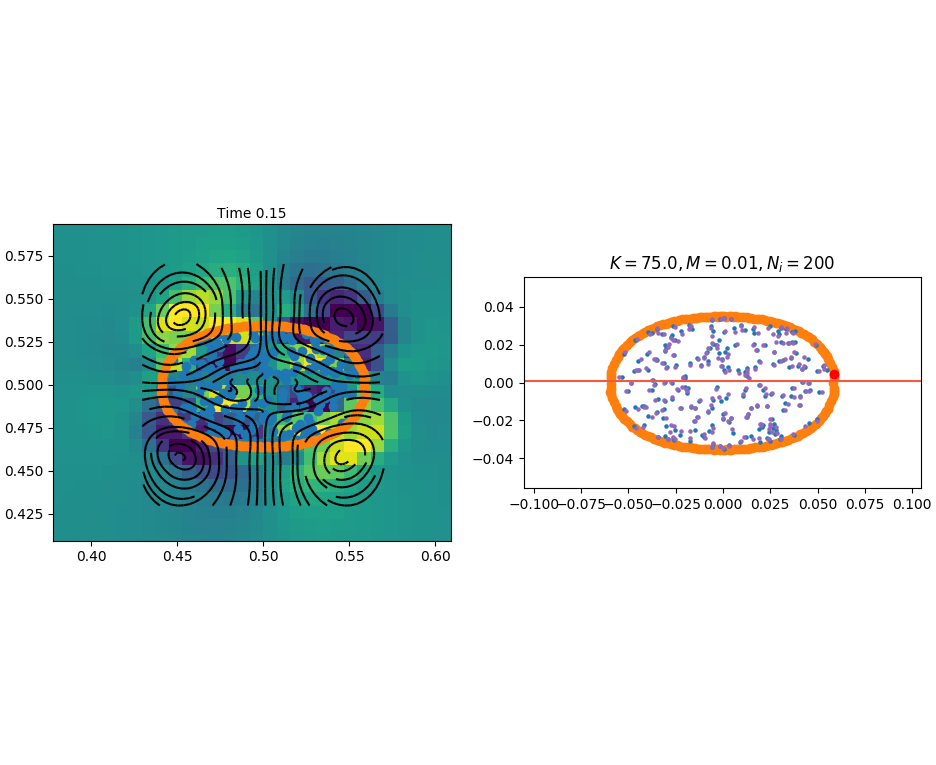

0
10
20
30
40
50


In [19]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    axj.set_aspect('equal', 'box')
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

Nc = int(N/2)
dN = int(rad*1.5/fluid.h)
dNRange = np.arange(Nc-dN, Nc+dN+1)
COORDS = np.meshgrid(dNRange, dNRange)

for i, u in enumerate(U):
#     if i%5!=3: continue
#     if i<25: continue
    if i%10==0: print(i)
#     print(i*nmod)
    im = [show_vorticity(u, L, ax)]
#     out = show_streamlines(u, L, ax)
    out = ax.streamplot(COORDS[0]*fluid.h, COORDS[1]*fluid.h, u[0][COORDS], u[1][COORDS], color='black')
    im.append(out.lines)
    im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    
    for k, X in enumerate([Xin, Xout]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        xout = Xout[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com
        out = xout - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
        im.append(axj.scatter(out[:,0], out[:,1], color=cmap(1), zorder=0))
        im.append(axj.scatter([out[0,0]], [out[0,1]], color='red'))  ## Mark theta=0
        im.append(axj.axhline(y=.5-com[1], color=RED(0.1+0.45*(1+np.sin(2*np.pi*i*nmod/Tper)))))
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(4)))
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

In [20]:
ani2 = animation.ArtistAnimation(fig, ims, interval=int(15*nmod), repeat_delay=1)

In [42]:
ani2.save('st_on_boundary_K75_amp30_per30_Kp15000_ptol1pt5h.gif', writer='imagemagick')
# ani2.save('ST_per30_mupt01_K10_amp60_tolpt25_Mpt01.gif', writer='imagemagick')
# ani2.save('ST_mupt01_K10_tolpt25_Mpt01_noforce.gif', writer='imagemagick')

# ani2.save('per5_mupt05_K250_amp80_otherMAX3.gif', writer='pillow')
# ani2.save('long1.gif', writer='pillow')

In [36]:
print(plt.rcParams["animation.convert_path"]  )
plt.rcParams["animation.writer"] = "imagemagick"

convert


In [21]:
def get_theta(X): return np.arctan2(X[:,:,1], X[:,:,0])
def get_radii(X): return np.linalg.norm(X, axis=2)



(51, 200)


<IPython.core.display.Javascript object>


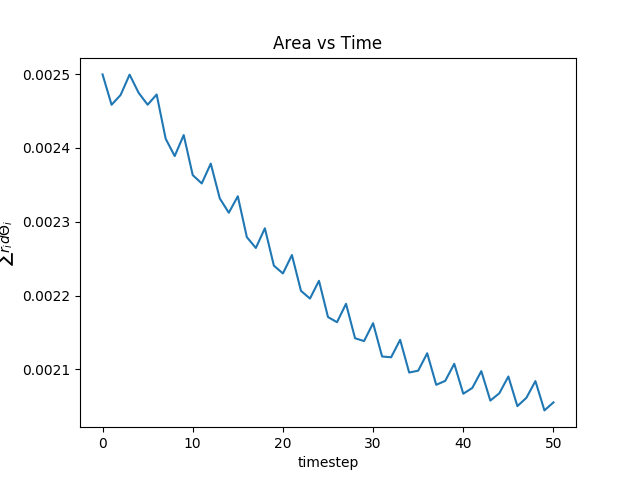

Text(0.5, 1.0, 'Area vs Time')

In [22]:
X0 = Xout[0] - np.mean(Xout[0], axis=1)[:, np.newaxis, :]

radii = get_radii(X0)
theta = get_theta(X0)
print(np.shape(theta))
dtheta = theta - np.roll(theta, 1, axis=1)
dtheta[dtheta>=np.pi] -= 2*np.pi
dtheta[dtheta<=-np.pi] += 2*np.pi

# print(np.shape(Xout[0]))
plt.figure()
# plt.plot(np.mean(radii, axis=1))
# plt.plot(dtheta[10])
plt.plot(np.sum(dtheta*radii**2, axis=1)/(2*np.pi))
plt.xlabel('timestep')
plt.ylabel('$\sum r_i d\Theta_i$')
plt.title('Area vs Time')

<IPython.core.display.Javascript object>


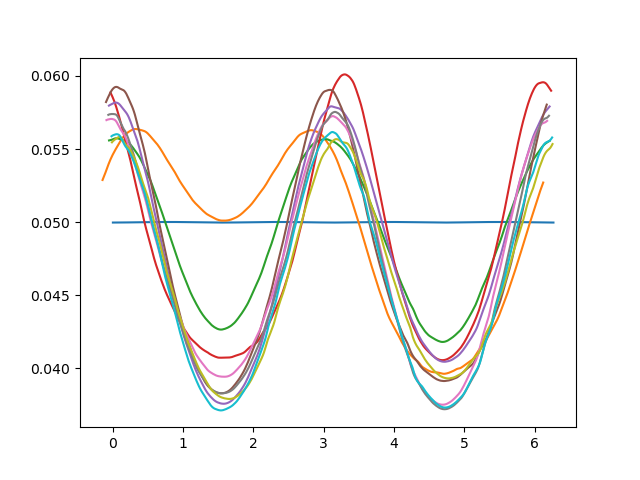

<IPython.core.display.Javascript object>


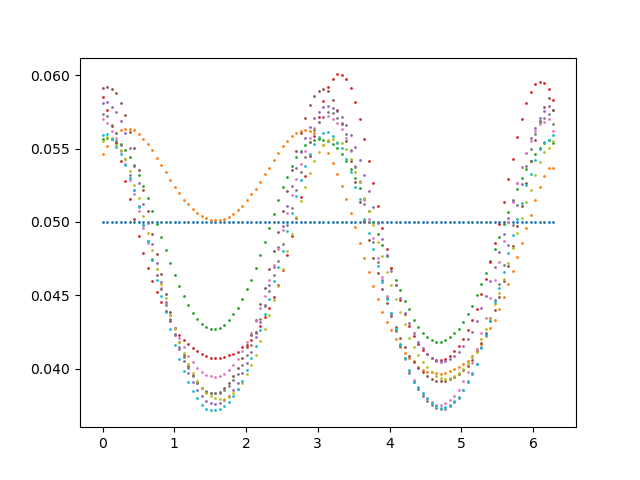

In [163]:
from scipy import interpolate
# thvals = get_theta(np.array(X[0]))

X0 = np.array(X[0] - np.mean(X[0], axis=1)[:, np.newaxis, :])
thvals = get_theta(X0)
rvals = get_radii(X0)

dth = np.roll(thvals, 1) - thvals
indices = [np.arange(len(t))[abs(dth[i])>np.pi] for i, t in enumerate(thvals)]
for j, ind in enumerate(indices):
    for i in ind:
        thvals[j][i:]+=2*np.pi
plt.figure()
# plt.plot(dth[0])


# plt.plot(X0[0,:,0], X0[0,:,1])
# # rvals = get_radii(np.array(X[0]))
# radii = get_radii(X0)

# print(np.shape(thvals))

# plt.figure()
# # plt.plot(rvals[0], thvals[0])


# [plt.plot(thvals[i]) for i in range(90,100)]
# thvals[thvals>2*np.pi] -= 2*np.pi

ivals = np.arange(0, 100, 10)
[plt.plot(thvals[i],rvals[i]) for i in ivals]

plt.figure()




tck = [interpolate.splrep(thvals[i], rvals[i], s=0) for i in range(len(thvals))]
# tck = interpolate.splrep(thvals[0], rvals[0], s=0)


# x = np.linspace(0, 2*np.pi, 100)
# y = np.sin(x)
# tck = interpolate.splrep(x,y, s=0)

xnew = np.linspace(0, 2*np.pi, 101)

# ynew = interpolate.splev(xnew, tck, der=0)
ynew = [interpolate.splev(xnew, itck, der=0) for itck in tck]

# [plt.scatter(thvals[i],rvals[i], s=1) for i in ivals]
[plt.scatter(xnew, ynew[i], s=1) for i in ivals]
# [plt.scatter(xnew, ynew, s=1) for i in ivals]



# plt.plot(x, y, 'x', xnew, ynew, xnew, np.sin(xnew), x, y, 'b')

# plt.legend(['Linear', 'Cubic Spline', 'True'])

# plt.axis([-0.05, 6.33, -1.05, 1.05])

# plt.title('Cubic-spline interpolation')

# plt.show()

<IPython.core.display.Javascript object>


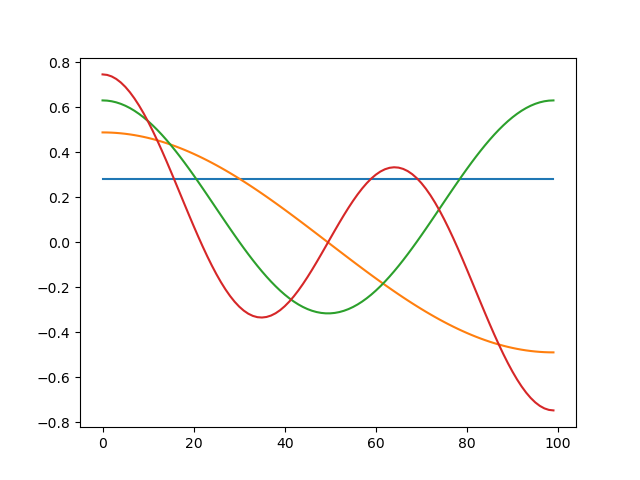

[[<matplotlib.lines.Line2D at 0x7f1938a835e0>],

In [98]:
from scipy.special import sph_harm

th = np.linspace(0, np.pi, 100)
plt.figure()
[plt.plot(sph_harm(0, n, 0, th)) for n in range(4)]

# Rigid Body

In [9]:
from rpib2 import RPIB2       #### 2D penalty IB object (droplet interior)

Kp = 7000
theta = np.pi/500
rad = 0.05
Ni = 100
nsteps = 1000
Tamp=60

####################################
  ########   Simulation   ########
####################################

#### Initialize Fluid+Droplets
fluid = FLUID(N=N, L=L, mu=mu)
fluid.dt = dt

# ########
# def channel(u):
#     u[0,0,:] = 5.
#     u[0,-1,:] = 5.
#     u[:,:,0] = 0
#     u[:,:,-1] = 0
    
# fluid.boundary = channel

########
# fluid.u[1] = 5.0
# # fluid.u[1] *= np.sin(np.linspace(0, 2*np.pi, N))[np.newaxis, :]
# fluid.u[1] *= np.linspace(0, 1, N)[np.newaxis, :]
insides = [RPIB2(SUNFLOWER(rad-fluid.h/2, positions[i], n=Ni), fluid.N, fluid.h, fluid.dt) for i in range(len(positions))]
solids = insides

#### Declare Forces
for inside in insides:
    inside.Kp = Kp    
    inside.M = M 
#     inside.bForce = lambda solid, Y: 0*GRAV(solid, Y)
#     inside.bForce = lambda solid, Y: GRAV(solid, Y) - 1*solid.V + 100*TRAPPING_PLANE(Y, fluid.L)

#     inside.bForce = lambda solid, Y:  GRAV(solid, Y, theta=theta) + Tamp*TRAPPING_PLANE(Y, fluid.L)*(1+np.sin(2*np.pi*fluid.t/(solid.dt*Tper))
    inside.bForce = lambda solid, Y:  GRAV(solid, Y, theta=theta) + Tamp*TRAPPING_PLANE(Y, fluid.L)#*(1+np.sin(2*np.pi*fluid.t/(solid.dt*Tper))
    
#### Values that we're tracking
delta = [[] for inside in insides]    ## Keep track of |X-Y|/h
V = [[] for inside in insides]
LL = [[] for inside in insides]

U = []
Xin = [[] for inside in insides]
Y = [[] for inside in insides]
for i in range(nsteps+1):
    iterate(fluid, solids)
    #### Keeping track of 'interior' properties
    for j, iin in enumerate(insides):
        delta[j].append(np.max(np.linalg.norm(iin.Y - iin.X, axis=1)))
        V[j].append(np.mean(iin.V, axis=0))
        LL[j].append(iin.L)
    if i%nmod==0:
        print(i)
        U.append(fluid.u.copy())
        for j, iin in enumerate(insides):
            Xin[j].append(iin.X.copy())
            Y[j].append(iin.Y.copy())
            

0
40
80
120
160
200
240
280
320
360
400
440
480
520
560
600
640
680
720
760
800
840
880
920
960
1000


<IPython.core.display.Javascript object>


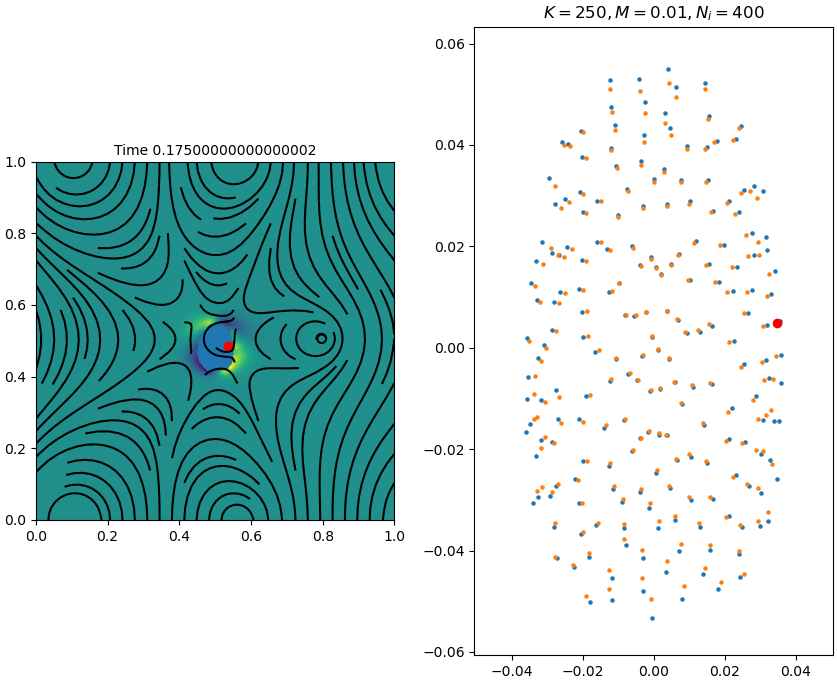

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750


In [36]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):

    print(i*nmod)
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
            im.append(ax.scatter(x[i][-1,0]%L, x[i][-1,1]%L, color='red'))
            im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
#         im.append(axj.scatter([ins[-1,0]], [ins[-1,1]], color='red'))  ## Mark theta=0
        
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(1)))
        im.append(axj.scatter([yins[-1,0]], [yins[-1,1]], color='red'))  ## Mark theta=0
        
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
#         im.append(ax.set_title('t={}'.format(1*fluid.t)))

        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

In [37]:
ani3 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)

<IPython.core.display.Javascript object>


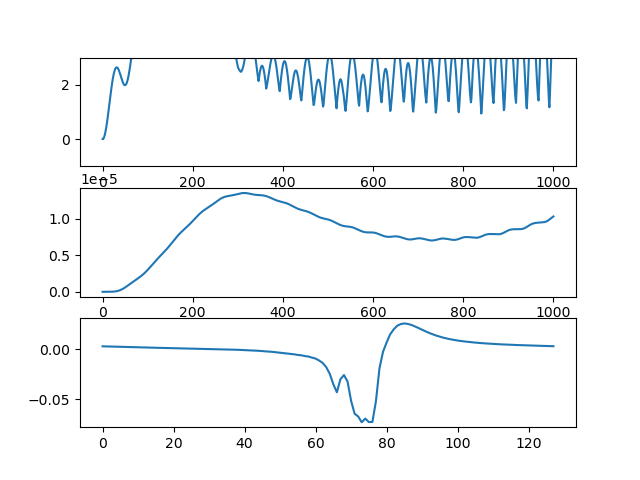

(26, 2, 128, 128)


In [12]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(3, 1, 1)
ax1.set_ylim([-1, 3])
for d in delta: ax1.plot(np.array(d)/fluid.h)
    
ax2 = fig2.add_subplot(3, 1, 2)       
for i in range(len(insides)): ax2.plot(0.5*dt*np.array(LL[i])/insides[i].I0)

    
ax = fig2.add_subplot(3, 1, 3)
print(np.shape(U))
ax.plot(U[5][ 0, 64, :])

In [33]:
for i in range(10):
    if i%5==0: continue
    print(i)

1
2
3
4
6
7
8
9
